In [1]:
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages')

from gensim.models.keyedvectors import KeyedVectors
from gensim.test.utils import datapath
from pathlib import Path

import numpy as np
import seaborn as sns
import random

model = KeyedVectors.load_word2vec_format(Path.cwd() / 'godfather_test.txt', binary=False)

In [2]:
Words_identities = model.index_to_key
Words_vector = model.vectors
for i in range(len(Words_vector)):
    Words_vector[i,:] = Words_vector[i,:] / max(Words_vector[i,:])

In [3]:
Words_vector.shape

(3448, 100)

In [4]:
%%time

N_Words = len(Words_identities)
N_Neurons = len(Words_vector[0])

WordsWeightMatrix = np.zeros((N_Neurons, N_Neurons))

for i in range(N_Words):
    
    Word_vector = np.array(Words_vector[i]).reshape((N_Neurons, 1))
    Word_vector_neg = np.zeros((N_Neurons, 1))
    Word_vector_neg[Word_vector[:,0]<0] = Word_vector[Word_vector[:,0]<0] 
    
    WordsWeightMatrix += Word_vector.dot(Word_vector.T) - Word_vector_neg.dot(Word_vector_neg.T)
    
    
    
    
    
AssemblyDecoder = np.zeros((N_Words, N_Neurons))
for i in range(N_Words):
    AssemblyDecoder[i,:] = np.array(Words_vector[i])

CPU times: user 125 ms, sys: 2.68 ms, total: 128 ms
Wall time: 127 ms


<AxesSubplot:>

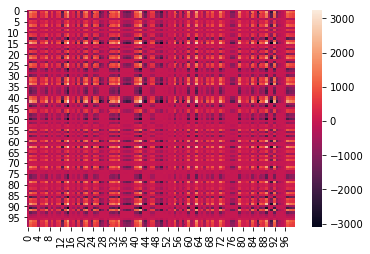

In [5]:
sns.heatmap(WordsWeightMatrix)

In [6]:
def WordsEIConnections(Words_vector, maxE=10, maxI=-7, baseE=1.8, baseI=1.1):
    
    N_Words = len(Words_vector)
    WordsDistances = np.zeros((N_Words, N_Words))
    
    for i in range(N_Words):
        Word_i = np.array(Words_vector[i])
#         Word_i[Word_i > 0] = 1
#         Word_i[Word_i <= 0] = 0
        
        for j in range(N_Words):
            Word_j = np.array(Words_vector[j])
#             Word_j[Word_j > 0] = 1
#             Word_j[Word_j <= 0] = 0
            
            difference = (Word_i - Word_j).reshape((len(Word_i), 1))
            distance = difference.T.dot(difference)

            WordsDistances[i, j] = distance
            
            
    EConnection = np.zeros((N_Words, N_Words))
    IConnection = np.zeros((N_Words, N_Words))
    
    for i in range(N_Words):
        EInputIndex = WordsDistances[i,:].argsort()[0:10]
        IInputIndex = WordsDistances[i,:].argsort()[0:200]
        
        EInputDistances = WordsDistances[i,:][EInputIndex]
        IInputDistances = WordsDistances[i,:][IInputIndex]
        
        EInputStrength = np.power(baseE, -EInputDistances) * maxE
        IInputStrength = np.power(baseI, -IInputDistances) * maxI
        
        EConnection[i, EInputIndex] = EInputStrength
        IConnection[i, IInputIndex] = IInputStrength
        
    return EConnection, IConnection, WordsDistances
    
            

def CellAssembly(NeuronConnection, AssemblyDecoder, Words_vector, Input, turn=5, sigma=1):
    
    N_Neurons = NeuronConnection.shape[0]
    N_Words = len(Words_vector)
    
    for itr in range(turn):
        
        Output = NeuronConnection.dot(Input)
        
        AssociatedWordsWeights = AssemblyDecoder.dot(Output)
        AssociatedWordsWeights = AssociatedWordsWeights / max(AssociatedWordsWeights)
        AssociatedWordsWeights = AssociatedWordsWeights + np.random.normal(0, sigma, N_Words).reshape((N_Words, 1))
#         AssociatedWordsWeights[AssociatedWordsWeights < 0] = 0
        
        Input = np.zeros((N_Neurons, 1))
        for i in range(N_Words):
            Word = np.array(Words_vector[i]).reshape((N_Neurons, 1))
            Weight = AssociatedWordsWeights[i]
            Input = Input + Word * Weight 
            
    return AssociatedWordsWeights
            
        


def WinnerTakeAll(WordsStrength, EConnection, IConnection, turn=4, sigma=1):
    
    global Words_identities
    
    Winners = []
    N_Words = len(WordsStrength)
    
    for t in range(turn):
        
        WordsStrength = WordsStrength / max(WordsStrength)
        WordsStrength = WordsStrength + np.random.normal(0, sigma, N_Words).reshape((N_Words, 1))
#         WordsStrength[WordsStrength < 0] = 0
        
        EInputs = np.zeros((N_Words, 1))
        IInputs = np.zeros((N_Words, 1))

        for i in range(N_Words):

            EInput = sum(WordsStrength[i,0] * EConnection[i,:])
            IInput = sum(WordsStrength[i,0] * IConnection[i,:])

            EInputs[i,0] = EInput
            IInputs[i,0] = IInput

        WordsStrength = WordsStrength + EInputs + IInputs
        Winners.append(np.array(Words_identities)[WordsStrength[:,0] > 0].tolist())
        
        if t == turn-1:
            WordsStrengthLast = WordsStrength / max(WordsStrength)
#             WordsStrengthLast[WordsStrengthLast[:,0]<0] = 0
#             WordsStrengthLast[WordsStrengthLast[:,0]>0] = 1
            

    return Winners, WordsStrengthLast



def HeteroAssociationChain(NeuronConnection, AssemblyDecoder, Words_vector, ChainLen=1, WordsNum=1, sigma=1, InputWords=None):
    
    global Words_identities
    
    N_Words = len(Words_vector)
    N_Neurons = len(Words_vector[0])
    
    if not InputWords:
        InputWords_index = random.sample(range(N_Words), WordsNum)
        Input = np.zeros((N_Neurons, 1))
        for i in InputWords_index:
            InputWord = np.array(Words_vector[i]).reshape((N_Neurons, 1))
            Input = Input + InputWord
    else:
        InputWords_index = [Words_identities.index(i) for i in InputWords]
        Input = np.zeros((N_Neurons, 1))
        for i in InputWords_index:
            InputWord = np.array(Words_vector[i]).reshape((N_Neurons, 1))
            Input = Input + InputWord
    
    HeteroAssociationResult = []
    HeteroAssociationResult.append(np.array(Words_identities)[InputWords_index])
    
    for Chain in range(ChainLen):

        E,I,D = WordsEIConnections(Words_vector)
        AssociatedWordsStrength = CellAssembly(NeuronConnection, AssemblyDecoder, Words_vector, Input, sigma=sigma, turn=2)
        Winners, WordsStrengthLast = WinnerTakeAll(AssociatedWordsStrength, E,I, turn=5, sigma=sigma)
        WinnersLast = Winners[-1]
        HeteroAssociationResult.append(WinnersLast)
        
        Input = np.zeros((N_Neurons, 1))
        for i in range(N_Words):
            InputWord = np.array(Words_vector[i]).reshape((N_Neurons, 1)) * WordsStrengthLast[i]
            Input = Input + InputWord
            
        
    
    return HeteroAssociationResult

    


In [7]:
%%time
HeteroChain1 = HeteroAssociationChain(WordsWeightMatrix, AssemblyDecoder, Words_vector, sigma=0.1, InputWords=['Corleone', 'Michael', 'gun'])

CPU times: user 42.5 s, sys: 253 ms, total: 42.8 s
Wall time: 42.2 s


In [8]:
for i in HeteroChain1:
    print(i, '\n')

['Corleone' 'Michael' 'gun'] 

['the', 'The', 'myth', 'a', 'if', 'mob', 'in', 'can', 'their', 'were', 'at', 'don’t', 'him', 'have', 'he', 'proclaim', 'Chapter', 'lot', 'low'] 



找几组单词，通过语义空间计算聚类结果，与细胞集群进行对比。

In [ ]:
%%time

for i in range(10):
    
    HeteroChain = HeteroAssociationChain(WordsWeightMatrix, AssemblyDecoder, Words_vector, sigma=0.1, InputWords=None)
    
    for j in HeteroChain:
        print(j, '\n')
    
    print('############')
    

['shattered'] 

['the', 'Western', 'myth', 'for', 'as', 'and', 'been', 'mob', 'you', 'into', 'his', 'have', 'her', 'do', 'she', 'proclaim', 'Chapter', 'club', 'Rizzi’s'] 

############
['important,'] 

['was', 'a', 'to', 'could', 'with', 'his', 'do', 'she', 'want', 'BOOK', 'Chapter'] 

############
